In [5]:
import os
import sys
sys.path.append('../')
from facerec.dataset_generator import DataGenerator
from facerec.siamese_models import get_siamese_model, train_model

In [6]:
IMGS_DIR = r'../data/faces/'
PAIRS_DIR = r'../data/pairs/'

SEED = 80808
BATCH_SIZE = 32
INPUT_SHAPE = (150, 150, 3)

TEST_POSITIVE_PAIRS_DIR = os.path.join(PAIRS_DIR, 'test_positive_pairs.csv')
TEST_NEGATIVE_PAIRS_DIR = os.path.join(PAIRS_DIR, 'test_negative_pairs.csv')

test_data = DataGenerator(
    positive_pairs_path=TEST_POSITIVE_PAIRS_DIR,
    negative_pairs_path=TEST_NEGATIVE_PAIRS_DIR,
    images_path=IMGS_DIR,
    input_shape=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    debug=True
)

print(f'Test data: {BATCH_SIZE * len(test_data)} samples in {len(test_data)} batches')

Test data: 3040 samples in 95 batches


In [7]:
from facerec.utils import contrastive_loss, accuracy, specificity, recall, precision
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

model_path = '../checkpoints/models/ResNet50-150-128/2023-09-22_02-27-43.hdf5'

In [8]:
siamese_model = get_siamese_model('ResNet50', input_shape=INPUT_SHAPE)
siamese_model.load_weights(model_path)

siamese_model.compile(loss=contrastive_loss, 
                        optimizer=Adam(0.0001, beta_1=0.99), 
                        metrics=[accuracy, precision, recall, specificity])

Model: "Pretrained_ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               6553728   
                                                                 
Total params: 30,141,440
Trainable params: 6,553,728
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
siamese_model.evaluate(test_data)

95/95 [==============================] - 38s 319ms/step - loss: 0.1434 - accuracy: 0.8414 - precision: 0.8752 - recall: 0.8016 - specificity: 0.8809


[0.1433681696653366,
 0.8414473533630371,
 0.8752285838127136,
 0.8016019463539124,
 0.8808656930923462]

In [10]:
import numpy as np

y_test = np.array([test_data.labels[i] for i in test_data.index])
y_pred = siamese_model.predict(test_data)

95/95 [==============================] - 32s 311ms/step


Best threshold = 0.528381


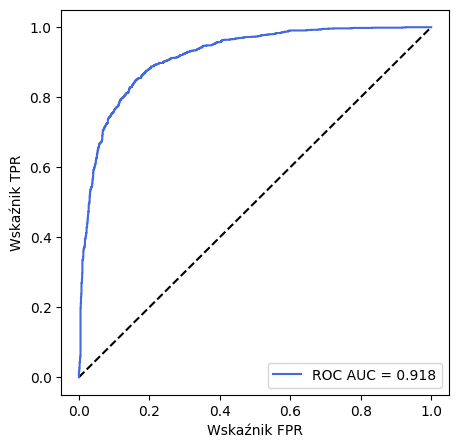

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=0)
roc_auc = auc(fpr, tpr)

J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best threshold = %f' % (best_thresh))

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC AUC = {:.3f}'.format(roc_auc), color='royalblue')
plt.xlabel('Wskaźnik FPR')
plt.ylabel('Wskaźnik TPR')
# plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [12]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc

# # Create an array of threshold values
# thresholds = np.linspace(0.4, 0.6, num=100)

# # Initialize lists to store TPR and FPR values for each threshold
# tpr_list = []
# fpr_list = []
# auc_list = []

# # Calculate TPR and FPR for each threshold
# for threshold in thresholds:
#     y_pred_binary = (y_pred < threshold).astype(int)
#     fpr, tpr, _ = roc_curve(y_test, y_pred_binary)
#     roc_auc = auc(fpr, tpr)
#     tpr_list.append(tpr)
#     fpr_list.append(fpr)
#     auc_list.append(roc_auc)

# # Plot ROC curve for each threshold
# plt.figure(figsize=(8, 5))
# for i in range(len(thresholds)):
#     plt.scatter(fpr_list[i], tpr_list[i], label=f'Threshold = {thresholds[i]}', s=1)

# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate (FPR)')
# plt.ylabel('True Positive Rate (TPR)')
# plt.title('ROC Curve for Different Thresholds')
# # plt.legend(loc='lower right')
# plt.show()